In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter
import math
from os import listdir
import random
import cv2

import pywt

import keras
from keras import backend as K
from keras.models import model_from_json
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Conv2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam
from keras import regularizers, optimizers, losses, initializers

import tensorflow as tf
from tensorflow.python.client import device_lib

Using TensorFlow backend.
/home/montero/.conda/envs/my_root/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
%run srcnn.py

In [3]:
print(device_lib.list_local_devices())
print(K.tensorflow_backend._get_available_gpus())

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
session = tf.Session(config=config)
keras.backend.set_session(session)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4085824725152256745
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10801908941
locality {
  bus_id: 1
}
incarnation: 11018112535396648396
physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:04:00.0, compute capability: 5.2"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 12051264308
locality {
  bus_id: 2
}
incarnation: 5487150672081232390
physical_device_desc: "device: 1, name: GeForce GTX TITAN X, pci bus id: 0000:83:00.0, compute capability: 5.2"
]
['/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1']


### Load images

In [4]:
def convertToYCbCr(x):
    return [image.convert('YCbCr') for image in x]

In [5]:
#Display images
def print_luminance(img, ch=1) :
    if (ch == 1) :
        plt.imshow(img, cmap=plt.get_cmap('gray'), interpolation='nearest')
    else :
        plt.imshow(img[:,:,0], cmap=plt.get_cmap('gray'), interpolation='nearest')

In [6]:
PATH = ""
TRAIN_FILE = PATH + "datasets/DIV2K_train_HR/"
obj_files = listdir(TRAIN_FILE )

In [7]:
obj_files[:5]

['0670.png', '0158.png', '0092.png', '0396.png', '0222.png']

In [8]:
#Load images

obj_img = []
train_img = []
valid_hr_img = []
valid_lr_img= []

for i in range(0,90):
    n = obj_files[i]
    obj_img.append(Image.open(TRAIN_FILE + n))
    
#Only consider the luminance channel (YCrCb)
ycbcr_obj = convertToYCbCr(obj_img)

In [9]:
#Convert images to numpy array
imgs_hd = [np.asarray(image)[:,:,0] for image in ycbcr_obj]

(1224, 2040)


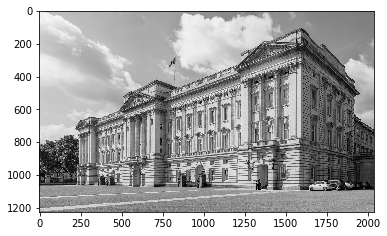

In [10]:
print(imgs_hd[1].shape)
print_luminance(imgs_hd[1])

In [11]:
p, t = get_input_images(imgs_hd[1])
t.shape

(1224, 2040)

### Generate train and test set

In [12]:
def getSubImage(img, height, width, centerX, centerY, len_interval, scale = 1) :
    window = window_size // scale
    return img[ height   : height//2 + window + centerX*len_interval,
                width // 2  + centerY*len_interval : width//2 + window + centerY*len_interval : ]

In [13]:
def retSize(x):
    return (x.shape[0], x.shape[1])

In [14]:
#Division by 4
window_size= 64
scale = 4
stride = 56

In [15]:
def getSubImages(image, stride = stride) :
    sub = []
    height, width = retSize(image)
    for h in range(0, height - window_size, stride) :
        for w in range (0, width - window_size, stride) : 
            sub.append(image[h : h + window_size, w : w + window_size])
    return sub

In [16]:
sub_labels = []
sub_samples = []
sub_valid_hr = []
sub_valid_lr = []

for i in range(0,90) :
    label, sample = get_input_images(imgs_hd[i], 4)
    
    #Calculate subimages
    sub_labels += getSubImages(label)
    sub_samples += getSubImages(sample)

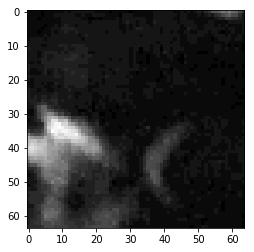

In [17]:
print_luminance(sub_labels[0])

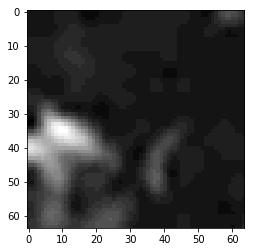

In [18]:
print_luminance(sub_samples[0])
#sub_samples[1].shape

#### Generate the wavelets subbands

In [19]:
def appendSubbands(l1,l2,l3,l4, dwt):
    l1 = np.append(l1 , dwt[0])
    l2 = np.append(l2, dwt[1][0])
    l3 = np.append(l3, dwt[1][1])
    l4 = np.append(l4, dwt[1][2])
    return (l1,l2,l3,l4)

In [20]:
def plot4images(im1, im2, im3, im4, ch=1) :
    size = (10, 10)
    fig = plt.figure(figsize=size)
    
    plt.subplot(221)
    plt.title("Approximation")
    print_luminance(im1, ch )
    plt.subplot(222)
    plt.title("Horizontal")
    print_luminance(im2, ch)
    plt.subplot(223)
    plt.title("Vertical")
    print_luminance(im3, ch)
    
    plt.subplot(224)
    plt.title("Diagonal")
    print_luminance(im4, ch)

def plot_waveletTrans(wt, ch=1) :
    plot4images(wt[0], wt[1][0], wt[1][1], wt[1][2], ch)

(32, 32)


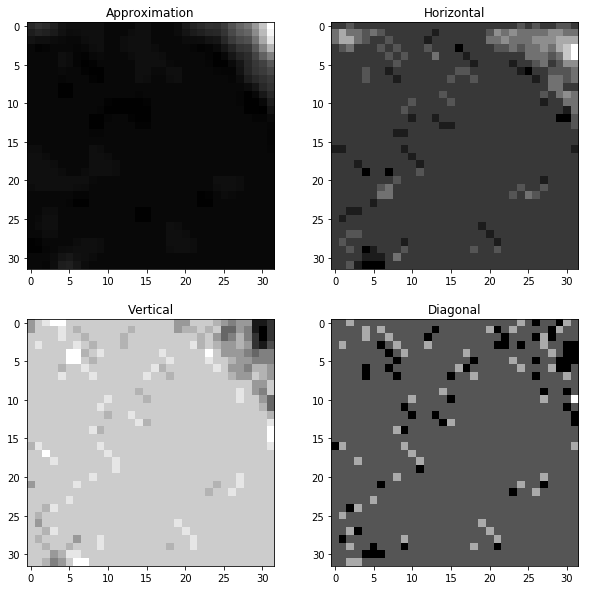

In [21]:
x_sample = sub_samples[1]
x_dwt = pywt.dwt2(x_sample, 'haar')
print(x_dwt[0].shape)
plot_waveletTrans(x_dwt)

111.0


numpy.ndarray

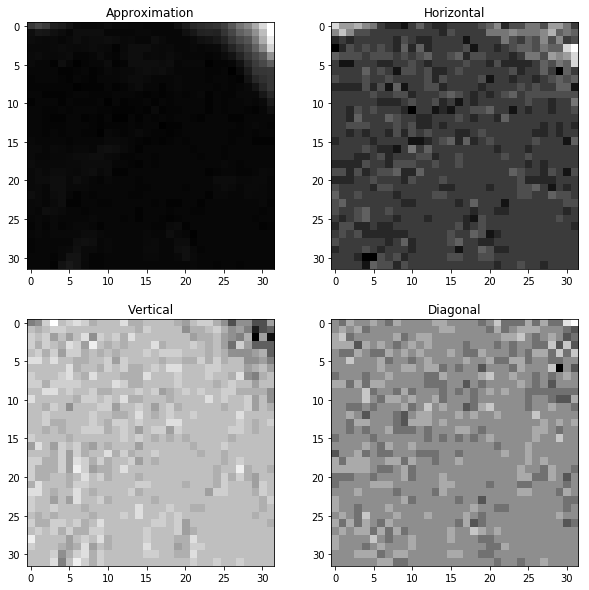

In [22]:
y_sample = sub_labels[1]
y_dwt = pywt.dwt2(y_sample, 'haar')
print(y_dwt[0].max())
plot_waveletTrans(y_dwt)
type(y_dwt[1][1])

In [24]:
shape = 32

test_list = []
train_list = []
for i in range(len(sub_labels)):
    y = sub_labels[i]
    x = sub_samples[i]
    
    dwt_y = pywt.dwt2(y, 'haar')
    dwt_x = pywt.dwt2(x, 'haar')    
    
    
    hight = np.asfarray([dwt_y[0], dwt_y[1][0], dwt_y[1][1], dwt_y[1][2]])
    x = np.asfarray([dwt_x[0], dwt_x[1][0], dwt_x[1][1], dwt_x[1][2]])
    
    y = hight - x
    
    test_list.append(y)
    train_list.append(x)

In [25]:
def equals(a, b) :
    t = a == b
    count = 0
    for a in range(0, len(t)) :
        for b in range(len(t[0])) :
            for c in range(len(t[1])) :
                if ( t[a, b, c] == False):
                    count = count + 1
    return count / (32*32*4) < 0.20
    

In [26]:
len(test_list)

78156

In [27]:
max_ = 0
for i in range(len(test_list)) :
    tmp = test_list[i].max()
    if (tmp > max_ ) :
        max_ = tmp
max_

406.00000000000006

In [28]:
test = np.asarray(test_list)
train = np.asarray(train_list)

In [29]:
test.shape

(78156, 4, 32, 32)

In [30]:
equals(train[10], test[10])

False

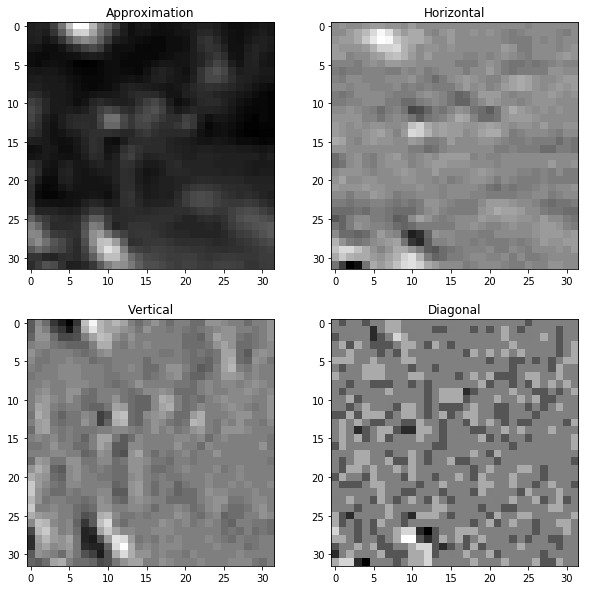

In [31]:
sample = train[10]
plot4images(sample[0], sample[1], sample[2], sample[3])

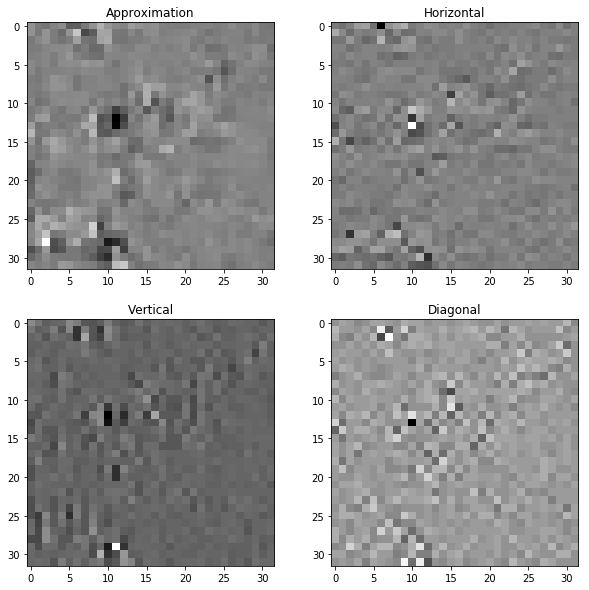

In [32]:
label = test[10]
plot4images(label[0], label[1], label[2], label[3])

#### Creating and Training the networks

In [33]:
def reshape(matrix, dwt_shape, channel='channels_last', ch=1) :
    if (channel == 'channels_last') :
        return matrix.reshape(-1, dwt_shape[0], dwt_shape[1], ch)
    else :
        return matrix.reshape(ch, -1, dwt_shape[0], dwt_shape[1])

In [34]:
input_shape = train.shape
input_shape
shape_ = (input_shape[1],input_shape[2], input_shape[3])

In [48]:
window_size

64

In [53]:
kernel_ini = initializers.RandomNormal(stddev=np.sqrt(2.0/9))
bias_ini = keras.initializers.Zeros()

adam = optimizers.Adam() 

In [35]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(5,5),strides=(1,1),padding='same',
                 activation='selu',
                 input_shape=shape_,
                 kernel_initializer=initializers.RandomNormal(stddev=np.sqrt(2.0/9)),
                 bias_initializer=bias_ini,
                 data_format='channels_first'))
for i in range(10) :
    model.add(Conv2D(64,
                     kernel_size=(3, 3),
                     strides=(1,1), 
                     activation='selu', 
                     padding='same', 
                     kernel_initializer=initializers.RandomNormal(stddev=np.sqrt(2.0/9/64)),
                 bias_initializer=bias_ini, data_format='channels_first'))

    
model.add(Conv2D(4, 
                 kernel_size=(3, 3),
                 strides=(1,1), 
                 padding='same', 
                 kernel_initializer=initializers.RandomNormal(stddev=np.sqrt(2.0/9/64)),
                 bias_initializer=bias_ini, data_format='channels_first'))

model.compile(optimizer=Adam(),
             loss='mean_absolute_error')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 32, 32)        6464      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 32, 32)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 32, 32)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 32, 32)        36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 32, 32)        36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 32, 32)        36928     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 32, 32)        36928     
__________

In [36]:
history_CNN = model.fit(train, test, validation_split=0.2, epochs=20, batch_size=64, verbose=1)

Train on 62524 samples, validate on 15632 samples
Epoch 1/20
62524/62524 [==============================] - 112s 2ms/step - loss: 7.4103 - val_loss: 7.2600
Epoch 2/20
62524/62524 [==============================] - 107s 2ms/step - loss: 6.5266 - val_loss: 7.1039
Epoch 3/20
62524/62524 [==============================] - 106s 2ms/step - loss: 6.3999 - val_loss: 7.0684
Epoch 4/20
62524/62524 [==============================] - 105s 2ms/step - loss: 6.3443 - val_loss: 7.0359
Epoch 5/20
62524/62524 [==============================] - 106s 2ms/step - loss: 6.3045 - val_loss: 6.9981
Epoch 6/20
62524/62524 [==============================] - 105s 2ms/step - loss: 6.2772 - val_loss: 6.9949
Epoch 7/20
62524/62524 [==============================] - 103s 2ms/step - loss: 6.2524 - val_loss: 6.9786
Epoch 8/20
62524/62524 [==============================] - 104s 2ms/step - loss: 6.2315 - val_loss: 6.9727
Epoch 9/20
62524/62524 [==============================] - 106s 2ms/step - loss: 6.2142 - val_loss: 6.9

In [38]:
save_model(model, "SRCNN_deep")

In [39]:
model = load_model("SRCNN_deep")

#### Original image and bicubic interpolated image

In [91]:
def patch_to_image(patches, height, width, strides=stride) :
    count = 0
    window_size = 64
    
    img = np.zeros((height, width))
    for h in range(0, height - window_size, stride) :
        for w in range (0, width - window_size, stride) : 
            img[h : h + window_size, w : w + window_size] = patches[count]
                                            #(img[h : h + window_size, w : w + window_size] + patches[count])/2
            count = count + 1
        
    assert(len(patches) == count)
    return img

In [92]:
valid_folder = "datasets/SR_Test/Set5/"

In [93]:
valid = listdir(valid_folder)
index = 3

In [94]:

im = Image.open(valid_folder + "/" + valid[index])

img = np.asarray(im.convert('YCbCr'))

img = img[:,:,0]
org, bic = get_input_images(img, 4)

h, w = retSize(org)
org.shape

(256, 256)

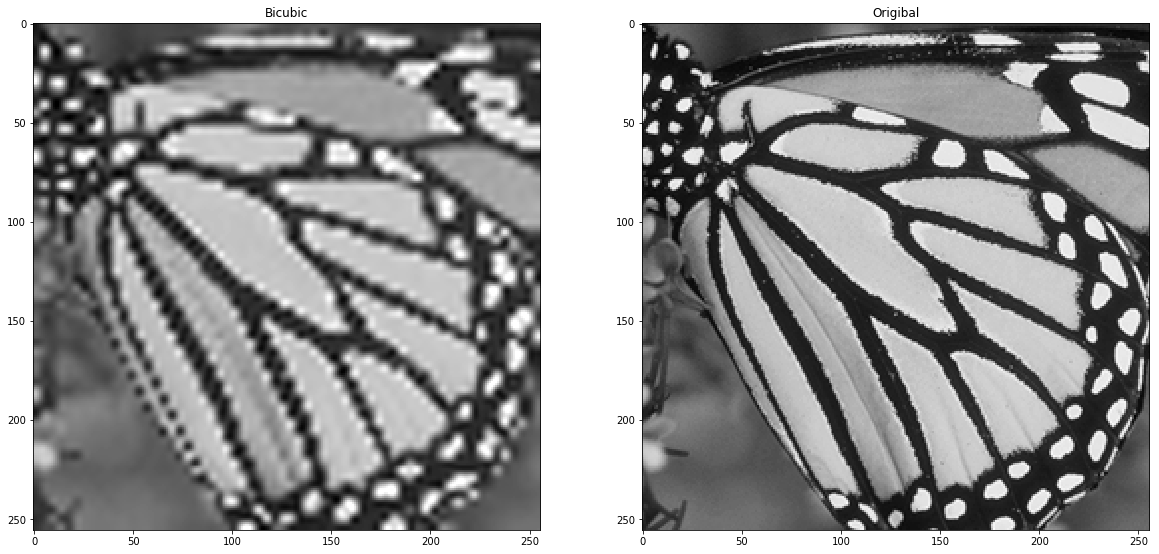

In [95]:
plot_images([org, bic], ["Origibal", "Bicubic"], size=(20, 10), ch=1)

In [96]:
sub_img = getSubImages(bic)
sub_img[0].shape

(64, 64)

In [97]:
low_w = []
for i in range(len(sub_img)):
    dwt_w = pywt.dwt2(sub_img[i], 'haar')
    
    dwt_w = np.asfarray([dwt_w[0], dwt_w[1][0], dwt_w[1][1], dwt_w[1][2]])
    
    low_w.append(dwt_w)


In [98]:
low_wavelet = np.asarray(low_w)
low_wavelet.shape

(16, 4, 32, 32)

In [99]:
pred_w = model.predict(low_wavelet)

In [100]:
res = low_wavelet + pred_w

sub_imgs = []
for i in range(len(res)) :
    patch = res[i]
    dwt = (patch[0], (patch[1], patch[2], patch[3]))
    wavelet = pywt.idwt2(dwt, 'haar')
    sub_imgs.append(wavelet)

In [101]:
sub_imgs[0].shape

(64, 64)

In [102]:
im = patch_to_image(sub_imgs, h, w, strides=16)

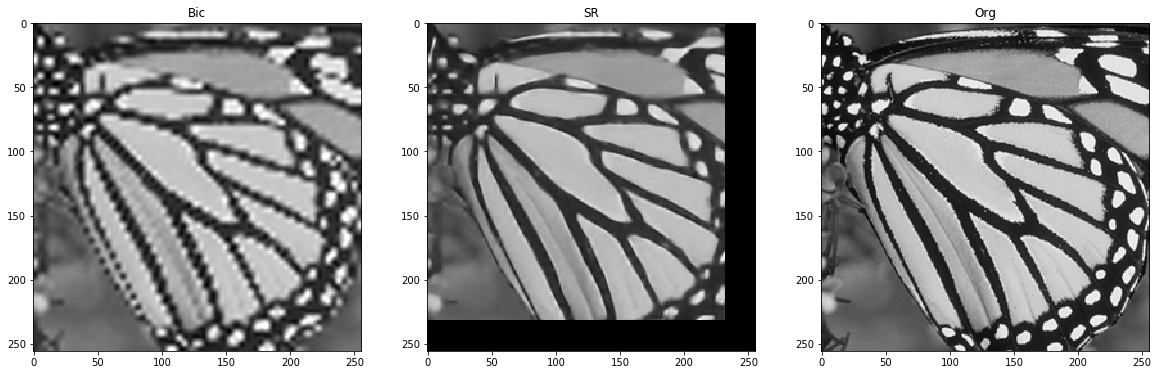

In [103]:
plot_images ([org, bic, im], ["Org", "Bic", "SR"], size= (20,20), ch=1) 

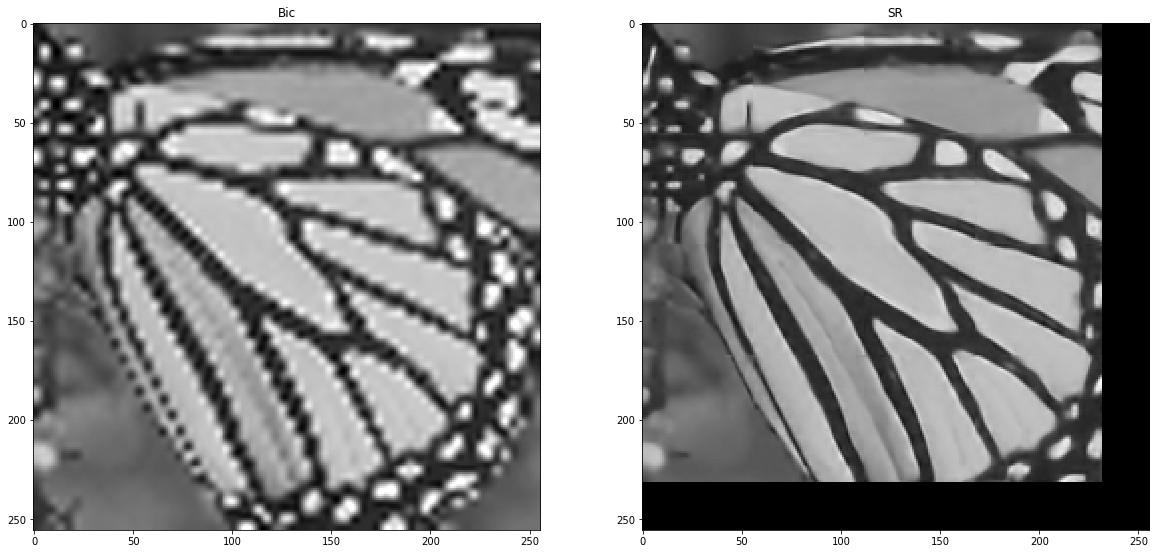

In [104]:
plot_images ([im, bic], ["SR", "Bic"], size= (20,20), ch=1) 